In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import KFold
import copy

c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import CSV and merge with drugs

In [2]:
selected_dim = 1024
dimension = pd.read_csv('../results/results' + str(selected_dim) + 'D_latent_space_gene_exp.tsv',sep='\t')
cell_line_name = pd.read_csv('../results_clean/cell_line_name.csv')
gdsc_drug = pd.read_csv('../results_clean/gdsc_drug_nodash.csv')
dimension.drop(columns=['Unnamed: 0'], inplace=True)
gdsc_drug.drop(columns=['Unnamed: 0'], inplace= True)
dimension['CELL_LINE_NAME'] = cell_line_name['CELL_LINE_NAME']
dimension_w_drug = pd.merge(dimension, gdsc_drug, on='CELL_LINE_NAME')
dimension_w_drug.drop(columns=['CELL_LINE_NAME'],inplace=True)
# dimension_w_drug = pd.get_dummies(dimension_w_drug, columns=['DRUG_NAME'])

In [3]:
dimension_w_drug = dimension_w_drug.sample(frac=1, random_state=33).reset_index(drop=True)
dimension_w_drug

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,LN_IC50,DRUG_NAME
0,0.000003,-0.000005,-0.000004,-0.000004,-1.947630e-06,-0.000007,0.000004,0.000005,-0.000008,0.000006,...,-0.000008,8.596951e-06,-0.000004,0.000007,-0.000006,1.384662e-06,-0.000009,-7.559261e-07,2.686879,LGK974
1,-0.000005,0.000006,0.000006,0.000006,3.244916e-06,0.000006,-0.000008,-0.000007,0.000009,-0.000007,...,0.000006,-5.632875e-06,0.000003,-0.000008,0.000006,3.438464e-06,-0.000010,4.930011e-06,5.515893,5-azacytidine
2,-0.000003,0.000008,0.000009,0.000009,1.274196e-05,0.000009,-0.000005,-0.000008,0.000009,-0.000008,...,0.000008,-7.977654e-06,0.000004,-0.000010,0.000008,1.155247e-05,-0.000020,1.835189e-05,2.400499,Sorafenib
3,-0.000003,0.000004,0.000005,0.000003,-5.588725e-07,0.000004,-0.000008,-0.000005,0.000007,-0.000005,...,0.000003,-4.927579e-07,0.000003,-0.000006,0.000004,-6.613679e-07,0.000002,-1.228852e-05,3.499021,PRT062607
4,-0.000007,0.000011,0.000012,0.000010,1.201331e-05,0.000011,-0.000009,-0.000010,0.000014,-0.000011,...,0.000011,-1.074133e-05,0.000011,-0.000013,0.000010,9.274476e-06,-0.000015,1.606120e-05,2.639762,AZD5438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157613,-0.000007,0.000008,0.000008,0.000008,8.162905e-06,0.000009,-0.000010,-0.000008,0.000013,-0.000008,...,0.000009,-7.332826e-06,0.000006,-0.000010,0.000009,2.017715e-05,-0.000010,4.866277e-06,2.482369,AGK2
157614,-0.000003,0.000005,0.000003,0.000004,-5.281099e-07,0.000003,-0.000007,-0.000005,0.000007,-0.000005,...,0.000004,-2.925420e-06,0.000004,-0.000005,0.000005,4.455080e-06,-0.000010,-1.907468e-06,2.919147,Cisplatin
157615,-0.000006,0.000008,0.000007,0.000008,5.563005e-06,0.000008,-0.000009,-0.000008,0.000011,-0.000008,...,0.000008,-8.932820e-06,0.000005,-0.000009,0.000008,1.004996e-05,-0.000013,1.334167e-05,4.440038,Serdemetan
157616,-0.000003,0.000007,0.000007,0.000009,1.268423e-05,0.000008,-0.000004,-0.000007,0.000008,-0.000007,...,0.000007,-7.991030e-06,0.000003,-0.000008,0.000007,8.460090e-06,-0.000029,1.755648e-05,3.617427,ABT737


### Seperate continuous and categorical columns

In [4]:
cat_cols = ['DRUG_NAME']
cont_cols = dimension_w_drug.drop(columns=['DRUG_NAME', 'LN_IC50']).columns
label_cols = ['LN_IC50']

In [5]:
cont_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022',
       '1023'],
      dtype='object', length=1024)

In [6]:
cat_cols

['DRUG_NAME']

### Categorify

In [7]:
for cat in cat_cols:
    dimension_w_drug[cat] = dimension_w_drug[cat].astype('category')

In [8]:
dimension_w_drug.dtypes

0             float64
1             float64
2             float64
3             float64
4             float64
               ...   
1021          float64
1022          float64
1023          float64
LN_IC50       float64
DRUG_NAME    category
Length: 1026, dtype: object

In [9]:
dimension_w_drug['DRUG_NAME'].head()

0           LGK974
1    5-azacytidine
2        Sorafenib
3        PRT062607
4          AZD5438
Name: DRUG_NAME, dtype: category
Categories (286, object): ['123138', '123829', '150412', '5-Fluorouracil', ..., 'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)', 'glutathione']

In [10]:
dimension_w_drug['DRUG_NAME'].cat.categories

Index(['123138', '123829', '150412', '5-Fluorouracil', '5-azacytidine',
       '50869', '615590', '630600', '667880', '720427',
       ...
       'WZ4003', 'Wee1 Inhibitor', 'Wnt-C59', 'XAV939', 'YK-4-279', 'ZM447439',
       'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)',
       'glutathione'],
      dtype='object', length=286)

In [11]:
drug_name = dimension_w_drug['DRUG_NAME'].cat.codes.values

In [12]:
cats = np.stack([drug_name],1)
cats = torch.tensor(cats, dtype=torch.int64)

In [13]:
cats

tensor([[146],
        [  4],
        [237],
        ...,
        [235],
        [ 16],
        [168]])

### Continuous variables to tensor

In [14]:
conts = np.stack([dimension_w_drug[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[ 2.9615e-06, -4.5133e-06, -4.2397e-06,  ...,  1.3847e-06,
         -8.8269e-06, -7.5593e-07],
        [-4.6223e-06,  6.0358e-06,  6.3223e-06,  ...,  3.4385e-06,
         -9.7063e-06,  4.9300e-06],
        [-2.8903e-06,  7.6155e-06,  9.4516e-06,  ...,  1.1552e-05,
         -2.0000e-05,  1.8352e-05],
        ...,
        [-6.0534e-06,  7.8305e-06,  7.0509e-06,  ...,  1.0050e-05,
         -1.2573e-05,  1.3342e-05],
        [-3.2886e-06,  6.8264e-06,  7.4798e-06,  ...,  8.4601e-06,
         -2.9261e-05,  1.7556e-05],
        [-6.0430e-06,  9.3195e-06,  1.0771e-05,  ...,  9.7452e-06,
         -2.3450e-05,  1.7629e-05]])

### Labels to tensor

In [15]:
labels = np.stack([dimension_w_drug[col].values for col in label_cols], 1)
labels = torch.tensor(labels, dtype=torch.float)
labels

tensor([[2.6869],
        [5.5159],
        [2.4005],
        ...,
        [4.4400],
        [3.6174],
        [4.5057]])

### Embedding size

In [16]:
cat_szs = [len(dimension_w_drug[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(286, 50)]

### Define model

In [17]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [18]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [19]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(286, 50)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=1074, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Loss and Optimizer Function

In [20]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
torch.cuda.get_device_name(0) # Get name device with ID '0'

'NVIDIA GeForce RTX 3060'

### Perform train/test splits

In [22]:
batch_size = conts.shape[0]
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [23]:
con_train.shape

torch.Size([126095, 1024])

In [24]:
y_test

tensor([[-0.0142],
        [ 1.1932],
        [ 2.3768],
        ...,
        [ 4.4400],
        [ 3.6174],
        [ 4.5057]])

In [25]:
y_train

tensor([[ 2.6869],
        [ 5.5159],
        [ 2.4005],
        ...,
        [-1.4227],
        [ 5.0628],
        [-6.8808]])

### Train model

In [26]:
import time
start_time = time.time()

epochs = 500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(loss_fn(y_pred, y_train)) # RMSE
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 4.06632090
epoch:  26  loss: 3.45487690
epoch:  51  loss: 3.13960123
epoch:  76  loss: 2.74727631
epoch: 101  loss: 2.33467817
epoch: 126  loss: 2.08860517
epoch: 151  loss: 1.98550105
epoch: 176  loss: 1.91268742
epoch: 201  loss: 1.84727287
epoch: 226  loss: 1.80065322
epoch: 251  loss: 1.76378798
epoch: 276  loss: 1.73173845
epoch: 301  loss: 1.70868433
epoch: 326  loss: 1.67802823
epoch: 351  loss: 1.66467977
epoch: 376  loss: 1.64594555
epoch: 401  loss: 1.63780987
epoch: 426  loss: 1.62024534
epoch: 451  loss: 1.60554051
epoch: 476  loss: 1.60007894
epoch: 500  loss: 1.58470333

Duration: 1292 seconds


### Plot loss function

Text(0.5, 0, 'epoch')

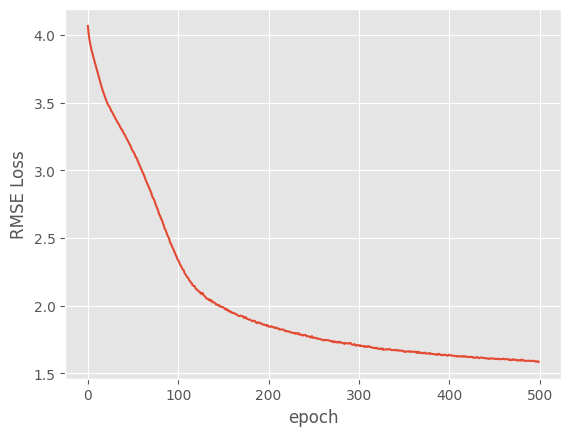

In [35]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')


### Validate Model

In [28]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(loss_fn(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 1.59683287


In [29]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  -2.6255  -0.0142   2.6114
 2.   3.9421   1.1932   2.7490
 3.   3.0200   2.3768   0.6432
 4.   3.5226   5.8819   2.3593
 5.   3.4249   3.6806   0.2557
 6.   1.9661   5.3496   3.3835
 7.   4.2164   4.4454   0.2290
 8.   3.3988   3.5117   0.1128
 9.   2.4886  -0.0613   2.5499
10.   1.0357   0.3543   0.6814
11.   5.2798   4.5224   0.7574
12.   3.8675   4.5157   0.6482
13.   4.6439   6.0162   1.3723
14.   3.4057   5.7954   2.3897
15.   3.8820   4.7382   0.8562
16.   1.4867  -0.0545   1.5412
17.   2.3678   2.1559   0.2119
18.   5.3248   8.0332   2.7084
19.   5.3819   5.4961   0.1142
20.   3.3323   4.7903   1.4581
21.   1.2468  -0.1294   1.3762
22.   2.9470   1.2184   1.7286
23.   0.7092   0.8689   0.1597
24.   1.3022   1.0359   0.2663
25.   0.9250   1.9203   0.9953
26.   5.1420   4.8219   0.3201
27.   4.5862   4.1070   0.4792
28.   3.4028   7.2403   3.8375
29.   2.8843   2.6463   0.2380
30.   0.0118  -0.1525   0.1643
31.   3.2461   2.1100   1.1361
32.   2.

### Min Max Scale X and extract y

In [3]:
scaler = MinMaxScaler()
col = dimension_w_drug.drop(columns=['LN_IC50']).columns
X = scaler.fit_transform(dimension_w_drug.drop(columns=['LN_IC50']))
X = pd.DataFrame(X, columns=col)
y = dimension_w_drug['LN_IC50']

scaled_df = X
scaled_df['LN_IC50'] = y

In [4]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,DRUG_NAME_Wee1 Inhibitor,DRUG_NAME_Wnt-C59,DRUG_NAME_XAV939,DRUG_NAME_YK-4-279,DRUG_NAME_ZM447439,DRUG_NAME_Zoledronate,DRUG_NAME_alpha-lipoic acid,DRUG_NAME_ascorbate (vitamin C),DRUG_NAME_glutathione,LN_IC50
0,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.902460
1,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.384381
2,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.372862
3,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.189364
4,0.098109,0.973217,0.934634,0.082488,0.003494,0.057198,0.040924,0.983428,0.953679,0.993825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.693711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157613,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.556376
157614,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.036685
157615,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.217061
157616,0.096684,0.982266,0.919321,0.076251,0.038997,0.069472,0.093618,0.937792,0.913322,0.953113,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.823341


## Predictor Portion

### Declare dataset class

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df):
 
        col = df.drop(columns=['LN_IC50']).columns
        x = df.drop(columns=['LN_IC50'])
        y = df['LN_IC50']
        x = np.array(x)
        y = np.array(y)
    
        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
 
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [6]:
# declare full dataset
full_dataset = MyDataset(scaled_df)

# split dataset to train and test
dim_np = np.array(scaled_df)
dim_col = scaled_df.columns
train, test = train_test_split(dim_np, train_size=0.8, shuffle=True, random_state=0)
train = pd.DataFrame(train, columns=dim_col)
test = pd.DataFrame(test, columns=dim_col)
# declare train and test dataset
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)

In [7]:
xgb_x_train = train.drop(columns=['LN_IC50'])
xgb_y_train = train['LN_IC50']

xgb_x_test = test.drop(columns=['LN_IC50'])
xgb_y_test = test['LN_IC50']

### Train with XGBoost

In [8]:
import xgboost as xgb
xgb_r = xgb.XGBRegressor()
xgb_r.fit(xgb_x_train, xgb_y_train)

y_pred = xgb_r.predict(xgb_x_test)

In [9]:
y_pred_tensor = torch.tensor(y_pred)
y_tensor = torch.tensor(xgb_y_test)
loss_function = nn.MSELoss()

loss_function(y_pred_tensor, y_tensor).item()


2.0796635844580593

### Declare model class

In [10]:
import torch.nn as nn
 
class predictor_model(nn.Module):
  def __init__(self):

    super().__init__()

    self.layers = nn.Sequential(
    nn.Linear(414, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

### Declare reset weights function for cross validation

In [11]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

### Declare loss function

In [12]:
loss_function = nn.MSELoss()

### Declare training parameters

In [19]:
model = predictor_model()
k_folds = 5
n_epochs = 20
torch.manual_seed(0)
batch_size = 10
lr = 0.0001
kfold = KFold(n_splits=k_folds, shuffle = True)
best_mse = np.inf
best_weights = None
history = []
device = torch.device('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr= lr)
model = model.to(device)

### Declare dataloaders

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

### Declare training function

In [21]:
def train(model, dataloader):
    count = 0
    model.train()
    current_loss = 0.0
    for i, data in enumerate(dataloader,0):
        x, y = data
        
        x = x.to(device)
        y = y.to(device)

        
        output = model(x)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        count = count + 1

    overall_loss = current_loss/count

    return overall_loss



### Declare validation function

In [22]:
def validate(model, dataloader):
    count = 0
    model.eval()
    current_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader,0):
            x, y = data
        
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)

            current_loss += loss.item()
            count = count + 1

    overall_loss = current_loss/count

    return overall_loss
    

In [23]:
def validate_new(model, X_test, y_test,best_mse, history,best_weights):
    model.eval()
    output = model(X_test)
    mse = loss_function(output, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

    return mse, best_mse, history, best_weights

### Execute Training

In [24]:
train_loss_list = []
val_loss_list = []
best_mse = np.inf
history = []
best_weights = None
for epoch in range(0, n_epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss = train(model, train_loader)
    train_loss_list.append(train_loss)
    print(f'Training MSE loss for epoch {epoch+1}: ' + str(train_loss))

    X_test = torch.tensor(np.array(xgb_x_test), dtype=torch.float32)
    y_test = torch.tensor(np.array(xgb_y_test), dtype=torch.float32)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    val_loss, best_mse, history, best_weights = validate_new(model, X_test, y_test, best_mse, history, best_weights)
    val_loss_list.append(val_loss)
    print(f'Validation MSE loss for epoch {epoch+1}: ' + str(val_loss))

Starting epoch 1
Training MSE loss for epoch 1: 7.6096666574961755


c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([31524])) that is different to the input size (torch.Size([31524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation MSE loss for epoch 1: 7.695577144622803
Starting epoch 2
Training MSE loss for epoch 2: 7.609565179198073
Validation MSE loss for epoch 2: 7.6954169273376465
Starting epoch 3
Training MSE loss for epoch 3: 7.609464114384526
Validation MSE loss for epoch 3: 7.695092678070068
Starting epoch 4
Training MSE loss for epoch 4: 7.6093551812742595
Validation MSE loss for epoch 4: 7.69457483291626
Starting epoch 5
Training MSE loss for epoch 5: 7.609242495368509
Validation MSE loss for epoch 5: 7.693907737731934
Starting epoch 6
Training MSE loss for epoch 6: 7.6091383731872995
Validation MSE loss for epoch 6: 7.693153381347656
Starting epoch 7
Training MSE loss for epoch 7: 7.609040229364051
Validation MSE loss for epoch 7: 7.692287921905518
Starting epoch 8
Training MSE loss for epoch 8: 7.608942730673428
Validation MSE loss for epoch 8: 7.6913533210754395
Starting epoch 9
Training MSE loss for epoch 9: 7.6088531989354875
Validation MSE loss for epoch 9: 7.690409183502197
Starting 

In [24]:
train_loss_list = []
val_loss_list = []

for epoch in range(0, n_epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss = train(model, train_loader)
    train_loss_list.append(train_loss)
    print(f'Training MSE loss for epoch {epoch+1}: ' + str(train_loss))

    val_loss = validate(model, test_loader)
    val_loss_list.append(val_loss)
    print(f'Validation MSE loss for epoch {epoch+1}: ' + str(val_loss))


Starting epoch 1


c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training MSE loss for epoch 1: 7.6495434621973795
Validation MSE loss for epoch 1: 7.6443190583152845
Starting epoch 2
Training MSE loss for epoch 2: 7.5672776602639935
Validation MSE loss for epoch 2: 7.629202788986935
Starting epoch 3
Training MSE loss for epoch 3: 7.559499932010197
Validation MSE loss for epoch 3: 7.625607852118377
Starting epoch 4


: 

: 